In [1]:
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pyfftw

import floatpy.readers.padeops_reader as por

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

resolution = 256
yslice = 90
savefig = False
large_span = True

L_y = 0.1143

if large_span:
    L_z = 1.0*L_y
    directory = '../LS_N%04d' %resolution
    output_prefix = 'plots/LS_N%04d_' %resolution
else:
    L_z = 0.25*L_y
    directory = '../N%04d' %resolution
    output_prefix = 'plots/N%04d_' %resolution

filename_prefix = directory + '/inclinedRM_'
outputfile = output_prefix + 'two_point_correlation.dat'

reader = por.PadeopsReader(filename_prefix, periodic_dimensions=(False,False,True))

ImportError: No module named pyfftw

In [2]:
reader.domain_size

(4096, 256, 256)

In [3]:
# Only get a single x-z slice
reader.sub_domain  = (0,yslice,0), (reader.domain_size[0]-1,    yslice, reader.domain_size[2]-1)

In [4]:
x, y, z = reader.readCoordinates()

In [5]:
steps = sorted(reader.steps)

In [6]:
step = 100
reader.step = step
rho, u, v, w, p, Y_CO2 = reader.readData(('rho', 'u', 'v', 'w', 'p', 'Massfraction_02'))

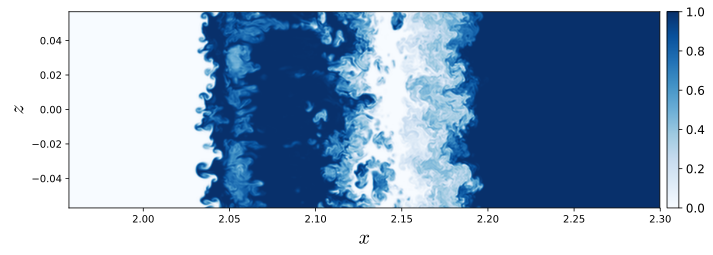

In [7]:
x_width = 3.*L_y

phi = 4.*Y_CO2*(1.-Y_CO2)
x_c = (phi*x).sum() / phi.sum()
xmin = x_c - 0.5*x_width
xmax = x_c + 0.5*x_width

fig, ax1 = plt.subplots(nrows=1, sharex=True, figsize=(10, 6.5))

extent = (x[0,0,0], x[-1,-1,-1], z[0,0,0], z[-1,-1,-1])
im1 = ax1.imshow(Y_CO2[:, 0, :].T, origin='lower', extent=extent, \
                 interpolation='none', cmap=plt.get_cmap('Blues'), vmin=0.0, vmax=1.0)

ax1.set_xlim((xmin,xmax))
ax1.set_xlabel(r'$x$', fontsize=20)
ax1.set_ylabel(r'$z$', fontsize=20)

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('right', size='2%', pad=0.1)
cbar1 = plt.colorbar(im1, cax=cax1)

plt.tick_params(labelsize=12)

plt.tight_layout()
plt.show()

In [8]:
nx, ny, nz = Y_CO2.shape

In [9]:
Y_CO2.dtype

dtype('float64')

In [10]:
f    = pyfftw.empty_aligned((nx, ny, nz), dtype='float64', order='F')
fhat = pyfftw.empty_aligned((nx, ny, nz/2+1), dtype='complex128', order='F')

fft  = pyfftw.FFTW(f, fhat, axes=(2,),direction='FFTW_FORWARD',  flags=('FFTW_MEASURE', ), \
                   threads=4, planning_timelimit=None)
ifft = pyfftw.FFTW(fhat, f, axes=(2,),direction='FFTW_BACKWARD', flags=('FFTW_MEASURE', ), \
                   threads=4, planning_timelimit=None)

In [11]:
# Remove mean and scale by variance
f[:,:,:] = ( Y_CO2[:,:,:] - np.mean(Y_CO2,axis=2,keepdims=True) )

# Get Fourier transform
fft(input_array=f, output_array=fhat)

# Get power spectral density
psd = fhat * fhat.conjugate()

# Get autocorrelation
ifft(input_array=psd, output_array=f)

array([[[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]]])

/home/users/akshays/.local/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in divide
  # This is added back by InteractiveShellApp.init_path()


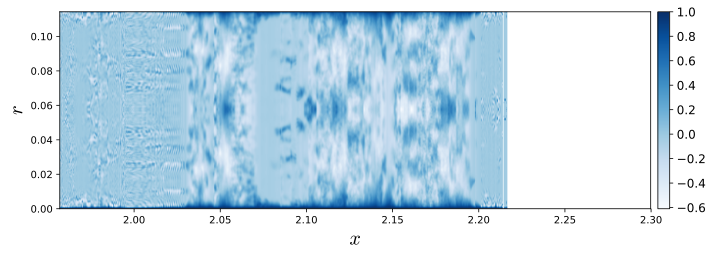

In [12]:
x_width = 3.*L_y

phi = 4.*Y_CO2*(1.-Y_CO2)
x_c = (phi*x).sum() / phi.sum()
xmin = x_c - 0.5*x_width
xmax = x_c + 0.5*x_width

fig, ax1 = plt.subplots(nrows=1, sharex=True, figsize=(10, 6.5))

extent = (x[0,0,0], x[-1,-1,-1], 0, L_z)
plot_var = (f[:, 0, :]/f[:, 0, 0:1]).T
im1 = ax1.imshow(plot_var, origin='lower', extent=extent, \
                 interpolation='none', cmap=plt.get_cmap('Blues'))

ax1.set_xlim((xmin,xmax))
ax1.set_xlabel(r'$x$', fontsize=20)
ax1.set_ylabel(r'$r$', fontsize=20)

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('right', size='2%', pad=0.1)
cbar1 = plt.colorbar(im1, cax=cax1)

plt.tick_params(labelsize=12)

plt.tight_layout()
plt.show()

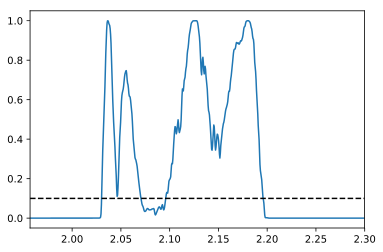

In [13]:
Y_mean = np.mean(Y_CO2, axis=2, keepdims=True)
phi = 4.*Y_mean*(1. - Y_mean)

plt.plot(x[:,0,0], phi[:,0,0])
plt.plot(x[:,0,0], 0.1*np.ones(nx), 'k--')
plt.xlim((xmin,xmax))
plt.show()

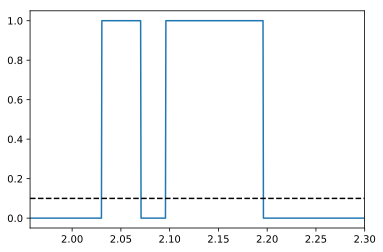

In [14]:
phi[phi > 0.1] = 1.0
phi[phi < 0.9] = 0.0

plt.plot(x[:,0,0], phi[:,0,0])
plt.plot(x[:,0,0], 0.1*np.ones(nx), 'k--')
plt.xlim((xmin,xmax))
plt.show()

In [15]:
Y_corr = np.sum( f / (f[:,:,0:1] + 1.e-10) * phi, axis=(0,1) ) / np.sum( phi, axis=(0,1) )

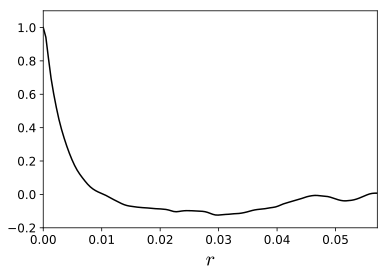

In [16]:
r_z = np.linspace(0., L_z, num=Y_corr.shape[0]+1)[:-1]
plt.plot(r_z, Y_corr, 'k-')
plt.xlim((0.,L_z/2))
plt.ylim((-0.2,1.1))
plt.xlabel(r'$r$', fontsize=20)
plt.tick_params(labelsize=12)
plt.show()

In [17]:
with open(outputfile, 'w') as fout:
    fout.write('# %24s %26s\n' %('r_z', 'Y_CO2'))
    for i in range(r_z.shape[0]):
        fout.write('%26.16e %26.16e\n' %(r_z[i], Y_corr[i]))
        
with open(outputfile, 'r') as fin:
    for line in fin:
        print line.strip()

#                      r_z                      Y_CO2
0.0000000000000000e+00     9.9999999997631606e-01
4.4648437500000000e-04     9.4166397521400091e-01
8.9296874999999999e-04     8.1502161437763687e-01
1.3394531249999999e-03     6.9553023094366728e-01
1.7859375000000000e-03     6.0260598024681689e-01
2.2324218750000000e-03     5.2193130644465280e-01
2.6789062499999999e-03     4.5015515535652439e-01
3.1253906250000001e-03     3.8987947885284530e-01
3.5718750000000000e-03     3.3759876706470782e-01
4.0183593749999998e-03     2.9002733924667701e-01
4.4648437500000001e-03     2.4700463901219175e-01
4.9113281250000003e-03     2.0833900030158770e-01
5.3578124999999997e-03     1.7408354622215899e-01
5.8042968750000000e-03     1.4509510157125133e-01
6.2507812500000003e-03     1.2104249133641630e-01
6.6972656249999997e-03     9.9842894430287280e-02
7.1437499999999999e-03     7.9832021865755692e-02
7.5902343750000002e-03     6.1317999550915998e-02
8.0367187499999996e-03     4.5576647080039681e